In [212]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from IPython.display import Audio
from scipy import signal
import librosa
from librosa import feature
from IPython.display import Audio
import librosa.display
from sklearn.model_selection import train_test_split
from pyAudioAnalysis import ShortTermFeatures
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Dropout
from keras.datasets import fashion_mnist
from sklearn.metrics import f1_score
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [3]:

path = "Crema/"
dataset = []
rates = []
labels=[]
for filename in glob.glob(os.path.join(path, '*.wav')):
    if('ANG' in filename):
        labels.append([1,0,0,0,0,0])
    if('FEA' in filename):
        labels.append([0,1,0,0,0,0])
    if('SAD' in filename):
        labels.append([0,0,1,0,0,0])
    if('HAP' in filename):
        labels.append([0,0,0,1,0,0])
    if('DIS' in filename):
        labels.append([0,0,0,0,1,0])
    if('NEU' in filename):
        labels.append([0,0,0,0,0,1])
    samples, sample_rate = librosa.load(filename)
    #samplerate, data = wavfile.read(filename)
    dataset.append(samples)
    rates.append(sample_rate)


In [4]:
max = 0
for i in range(len(dataset)):
    if max<len(dataset[i]):
        max = len(dataset[i])
for i in range(len(dataset)):
    dataset[i] =np.array(dataset[i])
    dataset[i]=np.pad(dataset[i],(0,max-len(dataset[i])),'constant')
    

In [ ]:

for i in range(len(dataset)):
        
        time = np.linspace(0,len(dataset[i]) / rates[i],num = len(dataset[i]))
        plt.figure(1)
        # title of the plot
        plt.title("Sound Wave")
        plt.xlabel("Time")
        plt.plot(time, dataset[i])
        plt.show()
        
        if np.max(dataset[i]) == 0:
            dataset[i] +=1
        Audio(dataset[i],rate = rates[i])



In [5]:
x_train,x_test,y_train,y_test = train_test_split(dataset,labels,test_size=0.3,random_state=123)
x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size=0.05,random_state=123)
print(np.shape(x_train))
print(np.shape(x_valid))
print(np.shape(x_valid))

(4948, 110361)
(261, 110361)


In [61]:
#data augmentation(pitch_shift) for 1D feautre space 
x_train_pitch=np.zeros((4948*2,110361))
for i in range(0,len(x_train)):
    x_train_pitch[2*i]=x_train[i]
    x_train_pitch[2*i+1]=librosa.effects.pitch_shift(x_train[i],22050,n_steps=4,bins_per_octave=24)
print(np.shape(x_train_pitch)) 

(9896, 110361)


In [46]:
y_train_pitch=np.zeros((4948*2,6))
for i in range (0,len(y_train)):
    y_train_pitch[2*i]=y_train[i]
    y_train_pitch[2*i+1]=y_train[i]
    

In [180]:
specs_x_train = []
specs_x_test = []
specs_x_valid = []
for i in range(len(x_train)):
    S_x_train = librosa.feature.melspectrogram(y=x_train[i], sr=22050, n_mels=128,fmax=8000,hop_length=int(len(x_train[i])/128)+1)
    specs_x_train.append(S_x_train)
    #librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    #plt.show()
for i in range(len(x_test)):
    S_x_test = librosa.feature.melspectrogram(y=x_test[i], sr=22050, n_mels=128,fmax=8000,hop_length=int(len(x_test[i])/128)+1)
    specs_x_test.append(S_x_test)
    #librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    #plt.show()
for i in range(len(x_valid)):
    S_x_valid = librosa.feature.melspectrogram(y=x_valid[i], sr=22050, n_mels=128,fmax=8000,hop_length=int(len(x_valid[i])/128)+1)
    specs_x_valid.append(S_x_valid)
    #librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    #plt.show()


In [76]:
featurespace_x_train = np.ones((4948*4,199))
featurespace_x_test = np.zeros((4466*2,199))
featurespace_x_valid = np.zeros((261*2,199))
for i in range(len(x_train_pitch)):
    F, f_names = ShortTermFeatures.feature_extraction(x_train_pitch[i], 22050, 0.050*22050, 0.025*22050,'false')
    featurespace_x_train[2*i]=(F[0])
    featurespace_x_train[2*i+1]=(F[1])
for i in range(len(x_test)):
    F, f_names = ShortTermFeatures.feature_extraction(x_test[i], 22050, 0.050*22050, 0.025*22050,'false')
    featurespace_x_test[2*i]=(F[0])
    featurespace_x_test[2*i+1]=(F[1])
for i in range(len(x_valid)):
    F, f_names = ShortTermFeatures.feature_extraction(x_valid[i], 22050, 0.050*22050, 0.025*22050,'false')
    featurespace_x_valid[2*i]=(F[0])
    featurespace_x_valid[2*i+1]=(F[1])

In [168]:
featurespace_x_test_final = featurespace_x_test[:2233*2]
featurespace_x_test_final = np.reshape(featurespace_x_test_final,(2233,199,2))
print(np.shape(np.array(featurespace_x_test_final)))

(2233, 199, 2)


In [ ]:
print(np.array(x_train_pitch[6]))

print(np.shape(np.array(featurespace_x_valid)))
print(np.shape(np.array(featurespace_x_test)))

In [185]:

featurespace_x_train =np.array(featurespace_x_train).reshape(4948*2,199,2)
featurespace_x_valid =np.array(featurespace_x_valid).reshape(261,199,2)
model = models.Sequential()

model.add(layers.Conv1D(16, kernel_size=3, activation='relu', input_shape=(199, 2)))
model.add(layers.Conv1D(16, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2,strides=None, padding='valid'))
model.add(layers.Conv1D(32, kernel_size=3, activation='relu'))
model.add(layers.Conv1D(32, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2,strides=None, padding='valid'))
model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2,strides=None, padding='valid'))
model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2,strides=None, padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(6,activation='softmax'))
model.summary()
print(np.shape(np.array(x_train)))
print(np.shape(np.array(y_train)))
print(np.shape(np.array(x_valid)))
print(np.shape(np.array(y_valid)))

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_259 (Conv1D)          (None, 197, 16)           112       
_________________________________________________________________
conv1d_260 (Conv1D)          (None, 195, 16)           784       
_________________________________________________________________
max_pooling1d_129 (MaxPoolin (None, 97, 16)            0         
_________________________________________________________________
conv1d_261 (Conv1D)          (None, 95, 32)            1568      
_________________________________________________________________
conv1d_262 (Conv1D)          (None, 93, 32)            3104      
_________________________________________________________________
max_pooling1d_130 (MaxPoolin (None, 46, 32)            0         
_________________________________________________________________
conv1d_263 (Conv1D)          (None, 44, 64)          

In [186]:
def scheduler(epoch,lr):
    if epoch < 10:
        return lr
    else:
        print(lr)
        return lr*tf.math.exp(-0.1)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#round(model.optimizer.lr.numpy(),5)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(np.array(featurespace_x_train), np.array(y_train_pitch), epochs=60,callbacks=[callback],batch_size = 128, 
                    validation_data=(np.array(featurespace_x_valid), np.array(y_valid)))

Epoch 1/60
78/78 [==============================] - 5s 51ms/step - loss: 1.7476 - accuracy: 0.2375 - val_loss: 1.6872 - val_accuracy: 0.2720
Epoch 2/60
78/78 [==============================] - 4s 47ms/step - loss: 1.6417 - accuracy: 0.3217 - val_loss: 1.5828 - val_accuracy: 0.3180
Epoch 3/60
78/78 [==============================] - 4s 47ms/step - loss: 1.5375 - accuracy: 0.3750 - val_loss: 1.4951 - val_accuracy: 0.3716
Epoch 4/60
78/78 [==============================] - 4s 48ms/step - loss: 1.4342 - accuracy: 0.4239 - val_loss: 1.4525 - val_accuracy: 0.4100
Epoch 5/60
78/78 [==============================] - 4s 51ms/step - loss: 1.3815 - accuracy: 0.4469 - val_loss: 1.3881 - val_accuracy: 0.4521
Epoch 6/60
78/78 [==============================] - 4s 51ms/step - loss: 1.3542 - accuracy: 0.4602 - val_loss: 1.3588 - val_accuracy: 0.4674
Epoch 7/60
78/78 [==============================] - 4s 49ms/step - loss: 1.3186 - accuracy: 0.4732 - val_loss: 1.3432 - val_accuracy: 0.4789
Epoch 8/60
78

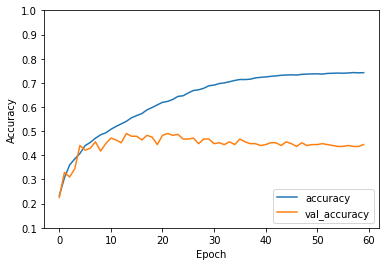

In [126]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

In [215]:
specs_x_train =np.array(specs_x_train).reshape(4948,128, 128,1)
specs_x_valid =np.array(specs_x_valid).reshape(261,128, 128,1)
model2D = models.Sequential()

model2D.add(layers.Conv2D(16, kernel_size=(5,5), activation='relu', input_shape=(128, 128,1)))
model2D.add(layers.Conv2D(16, kernel_size=(3,3), activation='relu'))
model2D.add(layers.MaxPooling2D(pool_size=(2,2),strides=2, padding='valid'))
model2D.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model2D.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model2D.add(layers.MaxPooling2D(pool_size=(2,2),strides=2, padding='valid'))
model2D.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model2D.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model2D.add(layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='valid'))
model2D.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
model2D.add(layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
model2D.add(layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='valid'))

model2D.add(layers.Flatten())
model2D.add(layers.Dense(256, activation='relu'))
model2D.add(layers.Dense(64, activation='relu'))
model2D.add(layers.Dense(6,activation='softmax'))
model2D.summary()
print(np.shape(np.array(specs_x_train)))
print(np.shape(np.array(y_train)))
print(np.shape(np.array(specs_x_valid)))
print(np.shape(np.array(y_valid)))

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 124, 124, 16)      416       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 122, 122, 16)      2320      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 61, 61, 16)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 59, 59, 32)        4640      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 57, 57, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 26, 26, 64)      

In [216]:
def scheduler(epoch,lr):
    if epoch < 10:
        return lr
    else:
        print(lr)
        return lr*tf.math.exp(-0.1)
model2D.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history2D = model2D.fit(np.array(specs_x_train), np.array(y_train), epochs=50,callbacks=[callback],batch_size = 128, 
                    validation_data=(np.array(specs_x_valid), np.array(y_valid)))

Epoch 1/50


C:\Users\YAHYA IHAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\keras\backend.py:4869: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


39/39 [==============================] - 93s 2s/step - loss: 1.6727 - accuracy: 0.3211 - val_loss: 1.8053 - val_accuracy: 0.3180
Epoch 2/50
39/39 [==============================] - 90s 2s/step - loss: 1.5359 - accuracy: 0.3723 - val_loss: 1.5197 - val_accuracy: 0.3946
Epoch 3/50
39/39 [==============================] - 88s 2s/step - loss: 1.4478 - accuracy: 0.4068 - val_loss: 1.4773 - val_accuracy: 0.4368
Epoch 4/50
39/39 [==============================] - 87s 2s/step - loss: 1.4298 - accuracy: 0.4224 - val_loss: 1.4822 - val_accuracy: 0.3870
Epoch 5/50
39/39 [==============================] - 85s 2s/step - loss: 1.3952 - accuracy: 0.4339 - val_loss: 1.4037 - val_accuracy: 0.4368
Epoch 6/50
39/39 [==============================] - 85s 2s/step - loss: 1.3406 - accuracy: 0.4545 - val_loss: 1.3947 - val_accuracy: 0.4406
Epoch 7/50
39/39 [==============================] - 82s 2s/step - loss: 1.3135 - accuracy: 0.4697 - val_loss: 1.3858 - val_accuracy: 0.4636
Epoch 8/50
39/39 [=============

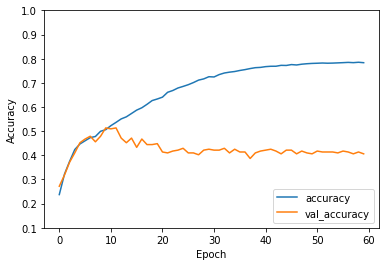

In [217]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

In [192]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
test_eval = model.evaluate(np.array(featurespace_x_test_final),np.array(y_test),verbose=1)

70/70 [==============================] - 1s 6ms/step - loss: 2.2807 - accuracy: 0.4008


In [208]:
predicted_classes = model.predict(featurespace_x_test_final)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
y_test_final = np.argmax(np.round(y_test),axis=1)
f1_score(y_test_final, predicted_classes,average='macro')

0.3701431364517073

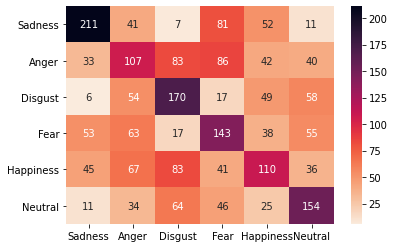

In [214]:
x_testcnn=np.array(featurespace_x_test_final).reshape(len(featurespace_x_test_final),199,2)
y_pred = model.predict(x_testcnn)
matrix = confusion_matrix(np.array(y_test).argmax(axis=1), y_pred.argmax(axis=1))
ax = sn.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = [ 'Sadness','Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral'], yticklabels = ['Sadness','Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral'])

In [226]:
specs_x_test =np.array(specs_x_test).reshape(2233,128, 128,1)
model2D.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
test_eval2D = model2D.evaluate(np.array(specs_x_test),np.array(y_test),verbose=1)

C:\Users\YAHYA IHAB\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\keras\backend.py:4869: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


70/70 [==============================] - 6s 86ms/step - loss: 4.6242 - accuracy: 0.4751


In [227]:
predicted_classes2D = model2D.predict(specs_x_test)
predicted_classes2D = np.argmax(np.round(predicted_classes2D),axis=1)
y_test_final2D = np.argmax(np.round(y_test),axis=1)
f1_score(y_test_final2D, predicted_classes2D,average='macro')

0.4509914511275676

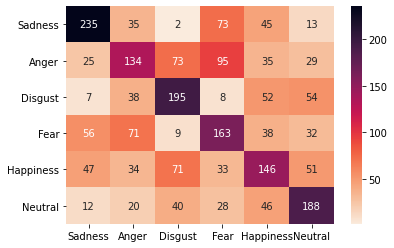

In [229]:
x_testcnn2D=np.array(specs_x_test).reshape(len(specs_x_test),128,128,1)
y_pred2D = model2D.predict(x_testcnn2D)
matrix2D = confusion_matrix(np.array(y_test).argmax(axis=1), y_pred2D.argmax(axis=1))
ax2D = sn.heatmap(matrix2D, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = [ 'Sadness','Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral'], yticklabels = ['Sadness','Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral'])